# Problem 3: Classifier using softmax and categorical cross-entropy

## Import image data

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

## Preparing image data and hyperparameters

Smaller batch sizes will obviously give better results, but I found that in fact, smaller batch sizes lead to overfitting, which reduces the accuracy of the classifier in the end.  A batch size of 32 was selected because any lower than that and overfitting becomes apparent, while higher and the gradient is not accurate enough.

Because this model takes the average gradient and uses stochastic gradient descent, it takes a while to converge, so the learning rate had to be hightened.  Any lower than 0.4, and the gradient changes too slowly to approach a good optimized minimum, while too high and it tends to jump around before also settling on a sub-optimal value.

In [0]:
train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels_original)

epochs = 10

# After much experimentation, I found that these parameters for batch size and learning rate give me the best results.
batch_size = 32
lr = 0.40

## Softmax activation functions

I created two softmax activation functions, one for use with multiple training examples, and one for just a single example.  The first activation function is used in batch training to handle all of the examples in the batch at once, while the second activation function is used in prediction of a number.

In [0]:
def activation_batch(z):
  # Calculate the exponent of each element.
  e_batch = np.exp(z)
  # Sum up all exponentiated elements for each example in the batch.
  e_sum_batch = np.sum(e_batch,axis=1)
  
  # Normalize each element in the batch by their respective sum.
  a = e_batch/e_sum_batch[:,None]
  return a

def activation(z):
  # Just exponentiate all elements then divide each one by the sum of all exponents.
  e = np.exp(z)
  return e/np.sum(e)

## Loss function

Used in marking the loss over each epoch as we train.

In [0]:
# The negative dot of the categorical labels with the log of the activation results.
def loss(a, y):
  return -y.dot(np.log(a))

## Creating and training the classifier

This function performs mini-batch gradient descent.  It returns the weight matrix and the vector of biases for each of the ten output neurons.  It also returns a list of loss averages over each epoch for plotting.


In [0]:
def classifier():
  # We have 10 output neurons, and each neuron has 28*28 weights coming in.
  weights = np.random.randn(10, 784)
  bias = np.random.randn(10)
  
  # The Kronecker Delta, used in calculating the partial derivatives, is just the identity matrix.
  kronecker = np.identity(10)
  
  num_ims = len(train_images)
  loss_avgs = []
  # We train over a number of epochs.
  for epoch in range(epochs):
    # On each epoch, shuffle the training data.
    shuffled_i = np.random.permutation(num_ims)
    X = train_images[shuffled_i]
    Y = train_labels[shuffled_i]
    # Record the average loss for each epoch.
    loss_epoch = 0.0
    
    # Take batches and perform gradient descent on them, using the average gradients
    # to update the weight and bias.
    for i in range(0, num_ims, batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        # The last batch may be smaller than the batch-size.
        num_x = len(y)
        
        # Find the weighted inputs by performing the dot product of each example with
        # the weights and adding the biases.
        z = x.dot(weights.T) + bias
        
        # Perform activation on the entire batch.
        a = activation_batch(z)
        
        # The calculation of the partial derivatives is broken into 2 steps:
        # 1. subtract the activation of each example from the kronecker delta.
        a_min_k = np.apply_along_axis(np.subtract, 1, a, kronecker)
        
        gradient_b = np.empty((num_x,10))
        gradient_w = np.empty((num_x,10,784))
        
        for k in range(num_x):
          # 2. Dot the previous result with the categorical labels to get the gradient with
          # respect to the biases for each example.
          gradient_b[k] = np.dot(y[k], a_min_k[k])
          # The gradient with respect to weights is just the gradient with respect to biases 
          # times the input.
          gradient_w[k] = gradient_b[k][:,None] * x[k]
          # Record the loss for each example.
          loss_epoch += loss(a[k],y[k])
        
        # Average both gradients to use in update step.
        gradient_b = np.mean(gradient_b, axis=0)
        gradient_w = np.mean(gradient_w, axis=0)
        
        # Update the weights and biases and move to the next epoch.
        weights = weights - lr * gradient_w
        bias = bias - lr * gradient_b
   
    # Record the overall loss for the epoch
    loss_avgs.append(loss_epoch/num_ims)
    print("Epoch %d/%d.\tLoss: %f" % (epoch+1, epochs, loss_epoch/num_ims))
  
  return (weights, bias, loss_avgs)

# Run the function to get the triple which represents the model.
(weights, bias, loss_avgs) = classifier()

Epoch 1/10.	Loss: 0.891747
Epoch 2/10.	Loss: 0.482861
Epoch 3/10.	Loss: 0.416084
Epoch 4/10.	Loss: 0.383953
Epoch 5/10.	Loss: 0.359764
Epoch 6/10.	Loss: 0.343730
Epoch 7/10.	Loss: 0.332545
Epoch 8/10.	Loss: 0.323213
Epoch 9/10.	Loss: 0.315893
Epoch 10/10.	Loss: 0.310402


## Visualizing loss values

I plot the loss averages obtained from the classifier. 

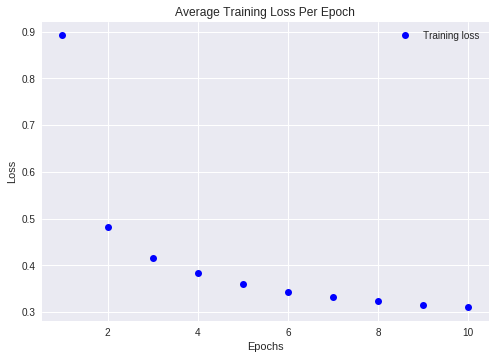

In [0]:
eps = range(1, epochs + 1)
plt.plot(eps, loss_avgs, 'bo', label='Training loss')
plt.title('Average Training Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
  

# Testing the classification model on test images.

I create a prediction function which takes the weights and biases returned from the model and a test image.  The function then dots the image data with the weight matrix, adds the biases, and then passes the result to the singular activation function, and then selects the argmax of the vector.  This argmax is the predicted number.

In [0]:

def predict(w, b, x):
  z = x.dot(w.T) + b
  return np.argmax(activation(z))

# Create two lists, one for storing the number of times the classifier
# correctly identified a number, and one for storing the number of times
# that number appears in the test data.
num_true = [0 for i in range(10)]
num_amount = [0 for i in range(10)]

# Test on all testing examples.
for i in range(10000):
  # Get the prediction and the true label.
  y_pred = predict(weights,bias, test_images[i])
  y_true = test_labels_original[i]
  
  # If the two are equal, record the success.
  num_amount[y_true]+=1
  if y_pred == y_true:
    num_true[y_true] += 1

# Print the accuracy of the classifier in recognizing each number, and print
# the overall accuracy.
for i in range(10): 
  print("Classifier's accuracy in recognizing %d: %f" % (i, num_true[i]/num_amount[i]))

print("\nOverall Accuracy: %f" % (sum(num_true)/10000))

Classifier's accuracy in recognizing 0: 0.977551
Classifier's accuracy in recognizing 1: 0.978855
Classifier's accuracy in recognizing 2: 0.916667
Classifier's accuracy in recognizing 3: 0.881188
Classifier's accuracy in recognizing 4: 0.929735
Classifier's accuracy in recognizing 5: 0.843049
Classifier's accuracy in recognizing 6: 0.949896
Classifier's accuracy in recognizing 7: 0.919261
Classifier's accuracy in recognizing 8: 0.856263
Classifier's accuracy in recognizing 9: 0.900892

Overall Accuracy: 0.916800
